In [ ]:
# Core
import numpy as np
import pandas as pd
from pathlib import Path

# Stats
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D PCA plots

# Preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import (
    pairwise_distances,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Models
from sklearn.ensemble import RandomForestClassifier


py -m pip install openpyxl

In [50]:

xls_path = r"resources\questionnaire_codebook_eHealth20252026.xlsx"
csv_path = r"resources\questionnaire_codebook_eHealth20252026.csv"

codebook = pd.read_excel(xls_path)
codebook.to_csv(csv_path, index=False)

In [ ]:
CSV_PATHS = [
    "resources/dataset_project_eHealth20252026.csv",
    "resources/questionnaire_codebook_eHealth20252026.csv",  
]


In [ ]:
# CSV loader
def load_csv_robust(path: str) -> pd.DataFrame:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    trials = [
        dict(encoding=None, sep=None, engine="python"), 
        dict(encoding="utf-8", sep=None, engine="python"),
        dict(encoding="latin-1", sep=None, engine="python"),
        dict(encoding=None, sep=",", engine="python"),
        dict(encoding=None, sep=";", engine="python"),
    ]
    last_err = None
    for kw in trials:
        try:
            return pd.read_csv(path, **kw)
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Could not read {path} – last error:\n{last_err}")


In [53]:
for p in CSV_PATHS:
    df = load_csv_robust(p)
    print(f"\n=== Loaded: {p} ===")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
    print("First 20 column names:", list(df.columns[:20]))
    print("\nDtypes:")
    print(df.dtypes.head(15))



=== Loaded: resources/dataset_project_eHealth20252026.csv ===
Shape: 221 rows × 96 cols
First 20 column names: ['age', 'gender', 'education', 'marital', 'income', 'audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10', 'dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5']

Dtypes:
age          float64
gender         int64
education    float64
marital      float64
income         int64
audit_1        int64
audit_2        int64
audit_3      float64
audit_4        int64
audit_5      float64
audit_6        int64
audit_7      float64
audit_8      float64
audit_9      float64
audit_10     float64
dtype: object

=== Loaded: resources/questionnaire_codebook_eHealth20252026.csv ===
Shape: 96 rows × 4 cols
First 20 column names: ['question', 'type', 'name of column', '[codification] options (if applicable)']

Dtypes:
question                                  object
type                                      object
name of column                  

We need to do some cleaning in dataset csv 
For the Nan values, replace NaN with the mean values of that question

Each prefix is the abbreviation for a different questionnaire or scale:

audit: Alcohol Use Disorders Identification Test

dast: Drug Abuse Screening Test

pgsi: Problem Gambling Severity Index

iat: Internet Addiction Test

pcl5: PTSD Checklist for DSM-5

mspss: Multidimensional Scale of Perceived Social Support

swls: Satisfaction With Life Scale

who5: WHO-5 Well-Being Index

In [54]:
questionnaires = [
    "audit",
    "dast",
    "pgsi",
    "iat",
    "pcl5",
    "mspss",
    "swls",
    "who5"
]

In [55]:
# Clean data
dataset = load_csv_robust(CSV_PATHS[0])
nan_rows_df1 = dataset.isna().any(axis=1).sum()

print(f"NaN rows in df1: {nan_rows_df1}")

flag_nan_or_empty = dataset.isna() | (dataset == "")
nan_or_empty_rows = dataset.index[flag_nan_or_empty.any(axis=1)].tolist()

print(f"Rows with NaN or empty string values: {nan_or_empty_rows}")

NaN rows in df1: 67
Rows with NaN or empty string values: [2, 6, 8, 13, 17, 18, 28, 29, 31, 35, 37, 39, 49, 53, 57, 59, 61, 62, 64, 66, 68, 69, 74, 79, 82, 83, 88, 91, 92, 95, 96, 100, 105, 107, 109, 110, 111, 114, 115, 116, 117, 120, 122, 129, 132, 133, 140, 141, 142, 149, 151, 156, 157, 162, 165, 170, 173, 181, 183, 195, 199, 201, 204, 206, 214, 215, 219]


In [56]:
df_filled = dataset.copy()

# Get only the questionnaire columns
questionnaire_cols = dataset.columns[5:]

for q in questionnaires:
    q_cols = [col for col in questionnaire_cols if col.startswith(q + "_")]
    dataset[q_cols] = dataset[q_cols].replace("", np.nan)
    dataset[q_cols] = dataset[q_cols].apply(pd.to_numeric, errors='coerce')
    for idx, row in dataset.iterrows():
        med = row[q_cols].median(skipna=True)
        df_filled.loc[idx, q_cols] = row[q_cols].fillna(med)

# Save the filled dataset locally with a new name
df_filled.to_csv('filled_personal_medians.csv', index=False)

Filling numerical Nan values age and income with median and categorical with mode

In [57]:
df = pd.read_csv("filled_personal_medians.csv")

cols_to_fill = ["age", "gender", "education", "marital", "income"]

print("NaN BEFORE filling:\n", df[cols_to_fill].isna().sum(), "\n")

for col in cols_to_fill:
    if col not in df.columns:
        print(f"Column '{col}' not found")
        continue

    # If it’s a numeric column,  fill it with the median
    if pd.api.types.is_numeric_dtype(df[col]):
        med = df[col].median(skipna=True)
        df[col] = df[col].fillna(med)
        print(f"{col}: filled NaN with median = {med}")

    else:
        # If it’s a categorical column, fill it with the frequent value(mod)
        s = df[col].astype("string").str.strip()
        s = s.replace({"": pd.NA, "nan": pd.NA, "None": pd.NA})
        mode_vals = s.mode(dropna=True)
        if len(mode_vals) > 0:
            mode_val = mode_vals[0]
            df[col] = s.fillna(mode_val)
            print(f" {col}: filled NaN with mode = '{mode_val}'")
        else:
            df[col] = s.fillna("Unknown")
            print(f"ℹ {col}: all values were NaN, fill with 'Unknown'")

print("\nNaN AFTER filling:\n", df[cols_to_fill].isna().sum())

# Overwrite the original file
df.to_csv("filled_personal_medians.csv", index=False)
print("\n Updated 'filled_personal_medians.csv' saved and all NaN values replaced")


NaN BEFORE filling:
 age          1
gender       0
education    1
marital      1
income       0
dtype: int64 

age: filled NaN with median = 29.0
gender: filled NaN with median = 1.0
education: filled NaN with median = 13.0
marital: filled NaN with median = 1.0
income: filled NaN with median = 25000.0

NaN AFTER filling:
 age          0
gender       0
education    0
marital      0
income       0
dtype: int64

 Updated 'filled_personal_medians.csv' saved and all NaN values replaced


Searching for the outliers at first 5 columns

In [59]:
personal_cols = ["age", "gender", "education", "marital", "income"]

print("\n=== Basic stats for first 5 personal columns ===")
for col in personal_cols:
    if col not in df.columns:
        print(f" Column '{col}' not found in dataset — skipping.")
        continue
    
    # If it’s a numeric column, display the minimum and maximum
    if pd.api.types.is_numeric_dtype(df[col]):
        col_min = df[col].min(skipna=True)
        col_max = df[col].max(skipna=True)
        print(f"{col}: min = {col_min}, max = {col_max}")
    else:
        # If it’s a categorical column, display the number of unique values and the top 3 most frequent ones
        unique_vals = df[col].dropna().unique()
        print(f"{col}: {len(unique_vals)} unique values → {df[col].value_counts().head(3).to_dict()}")


=== Basic stats for first 5 personal columns ===
age: min = 18.0, max = 40.0
gender: min = 0, max = 3
education: min = 5.0, max = 25.0
marital: min = 0.0, max = 5.0
income: min = 10000, max = 96600


Searching for the outliers in the other columns

In [60]:
# Manually declare the first 5 columns, the ones with personal info
excluded_cols = ["age", "gender", "education", "marital", "income"]

# Select only numeric questionnaire columns (excluding first 5)
questionnaire_cols = [
    c for c in df.columns
    if c not in excluded_cols and pd.api.types.is_numeric_dtype(df[c])
]

print(f"Number of questionnaire columns: {len(questionnaire_cols)}")

# Compute z-scores for those columns
z_scores = np.abs(stats.zscore(df[questionnaire_cols], nan_policy='omit'))

# Create a boolean mask of outliers (|z| > 3)
outlier_mask = (z_scores > 3)

# Count outliers per column
outlier_counts = pd.DataFrame({
    "num_outliers": outlier_mask.sum(axis=0).astype(int),
    "percent_outliers": (outlier_mask.sum(axis=0) / len(df) * 100).round(2)
})

print("\n=== Outlier Summary (|z| > 3) ===")
display(outlier_counts.sort_values("num_outliers", ascending=False).head(20))

# Mark rows that have at least one outlier
df["has_outlier"] = outlier_mask.any(axis=1)

print(f"\nRows with at least one outlier: {df['has_outlier'].sum()} of {len(df)} total")

# outlier_counts.to_csv("outlier_summary_questionnaires.csv")

Number of questionnaire columns: 91

=== Outlier Summary (|z| > 3) ===


,num_outliers,percent_outliers
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0



Rows with at least one outlier: 0 of 221 total


Summing the values of all questions to the total for each problem

In [62]:
df = pd.read_csv("filled_personal_medians.csv")

# Define a safe selector: only questions like AUDIT_1, AUDIT_2, ...
def compute_total(prefix):
    cols = [c for c in df.columns if c.upper().startswith(prefix + "_")]
    print(f"{prefix}: found {len(cols)} item columns ->", cols[:10], "..." if len(cols) > 10 else "")
    if cols:
        # convert to numeric just in case
        df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
        df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)
        print(f"{prefix}_total added.")
    else:
        print(f"No columns found for {prefix} (check column names).")

# Compute totals for all questionnaire
for prefix in ["AUDIT", "DAST", "IAT", "PGSI", "PCL5", "MSPSS", "SWLS", "WHO5"]:
    compute_total(prefix)

# Quick verification
print(df[[c for c in df.columns if c.endswith("_total")]].head())

# Overwrite the original csv
df.to_csv("filled_personal_medians.csv", index=False)

# Re-load to make sure it was saved
check = pd.read_csv("filled_personal_medians.csv")
print("Totals present after reload:", [c for c in check.columns if c.endswith("_total")])

AUDIT: found 10 item columns -> ['audit_1', 'audit_2', 'audit_3', 'audit_4', 'audit_5', 'audit_6', 'audit_7', 'audit_8', 'audit_9', 'audit_10'] 
AUDIT_total added.
DAST: found 10 item columns -> ['dast_1', 'dast_2', 'dast_3', 'dast_4', 'dast_5', 'dast_6', 'dast_7', 'dast_8', 'dast_9', 'dast_10'] 
DAST_total added.
IAT: found 20 item columns -> ['iat_1', 'iat_2', 'iat_3', 'iat_4', 'iat_5', 'iat_6', 'iat_7', 'iat_8', 'iat_9', 'iat_10'] ...
IAT_total added.
PGSI: found 9 item columns -> ['pgsi_1', 'pgsi_2', 'pgsi_3', 'pgsi_4', 'pgsi_5', 'pgsi_6', 'pgsi_7', 'pgsi_8', 'pgsi_9'] 
PGSI_total added.
PCL5: found 20 item columns -> ['pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7', 'pcl5_8', 'pcl5_9', 'pcl5_10'] ...
PCL5_total added.
MSPSS: found 12 item columns -> ['mspss_1', 'mspss_2', 'mspss_3', 'mspss_4', 'mspss_5', 'mspss_6', 'mspss_7', 'mspss_8', 'mspss_9', 'mspss_10'] ...
MSPSS_total added.
SWLS: found 5 item columns -> ['swls_1', 'swls_2', 'swls_3', 'swls_4', 'swls_5'

C:\Users\Visnja\AppData\Local\Temp\ipykernel_23588\816773324.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{prefix}_total"] = df[cols].sum(axis=1, skipna=True)


making a new db just with total values and first 5 columns

In [63]:
# Select the personal columns (first 5)
personal_cols = ["age", "gender", "education", "marital", "income"]

# Select all total score columns (those ending with "_total")
total_cols = [c for c in df.columns if c.endswith("_total")]

# Combine them
columns_to_keep = personal_cols + total_cols

# Create a new DataFrame
df_totals = df[columns_to_keep].copy()

# Quick check
print(df_totals.head())

# Save to a new CSV file
output_name = "totals_with_personal_info.csv"
df_totals.to_csv(output_name, index=False)
print(f"Saved new dataset: {output_name}")

    age  gender  education  marital  income  AUDIT_total  DAST_total  \
0  39.0       0        8.0      1.0   14000         25.0         0.0   
1  18.0       1        5.0      1.0   25000         16.0         0.0   
2  40.0       0       13.0      2.0   56000          0.0         8.0   
3  24.0       1       22.0      0.0   35000          7.0         8.0   
4  19.0       1       22.0      1.0   42000         14.0         4.0   

   IAT_total  PGSI_total  PCL5_total  MSPSS_total  SWLS_total  WHO5_total  
0       39.0        24.0         0.0         51.0         8.0        13.0  
1       33.0         8.0         6.0         43.0        14.0         7.0  
2       60.0         0.0        50.0         18.0         8.0        13.0  
3       56.0         0.0        63.0         26.0        15.0        11.0  
4        0.0         1.0         8.0         61.0        27.0        20.0  
Saved new dataset: totals_with_personal_info.csv


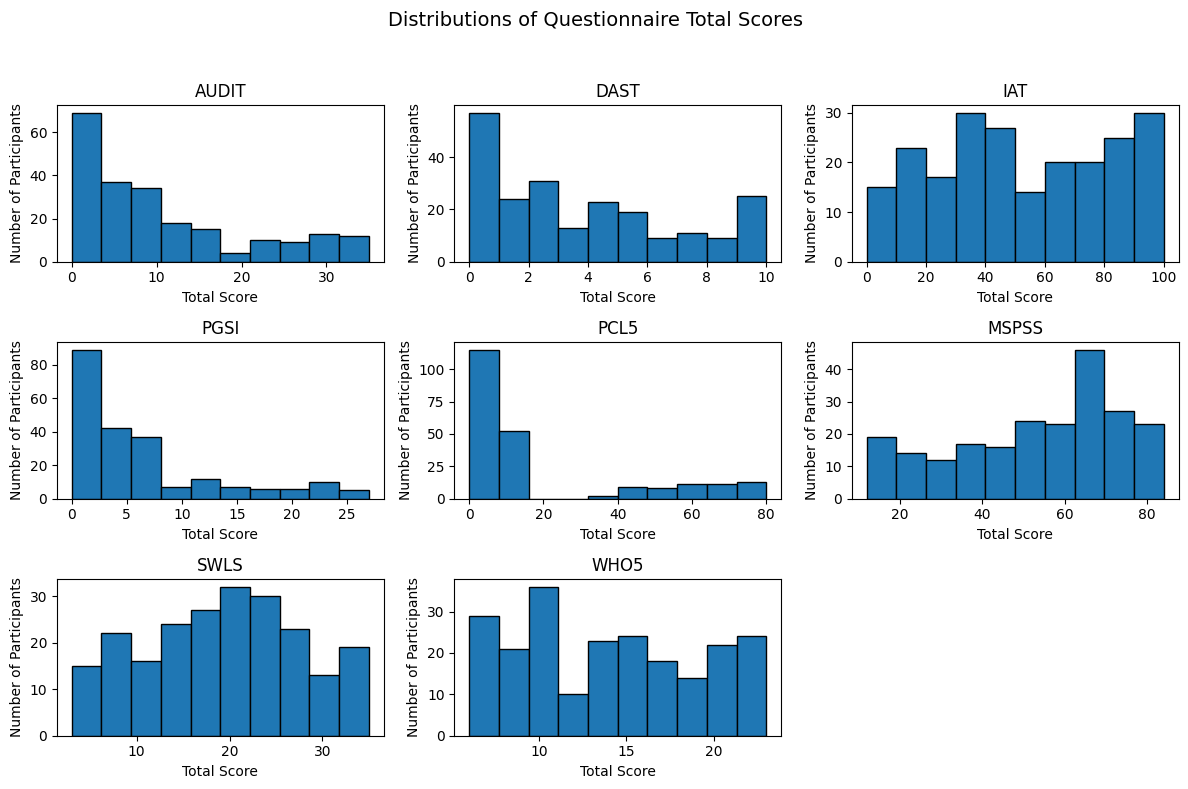

In [64]:
# All columns that end with "_total"
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Create histograms for each total score
axes = df_totals[totals].hist(
    bins=10,
    figsize=(12, 8),
    edgecolor='black',
    grid=False
)

# Add common labels
for ax in axes.flatten():
    ax.set_xlabel("Total Score")          # x-axis
    ax.set_ylabel("Number of Participants")  # y-axis
    ax.set_title(ax.get_title().replace("_total", "").upper())

plt.suptitle("Distributions of Questionnaire Total Scores", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

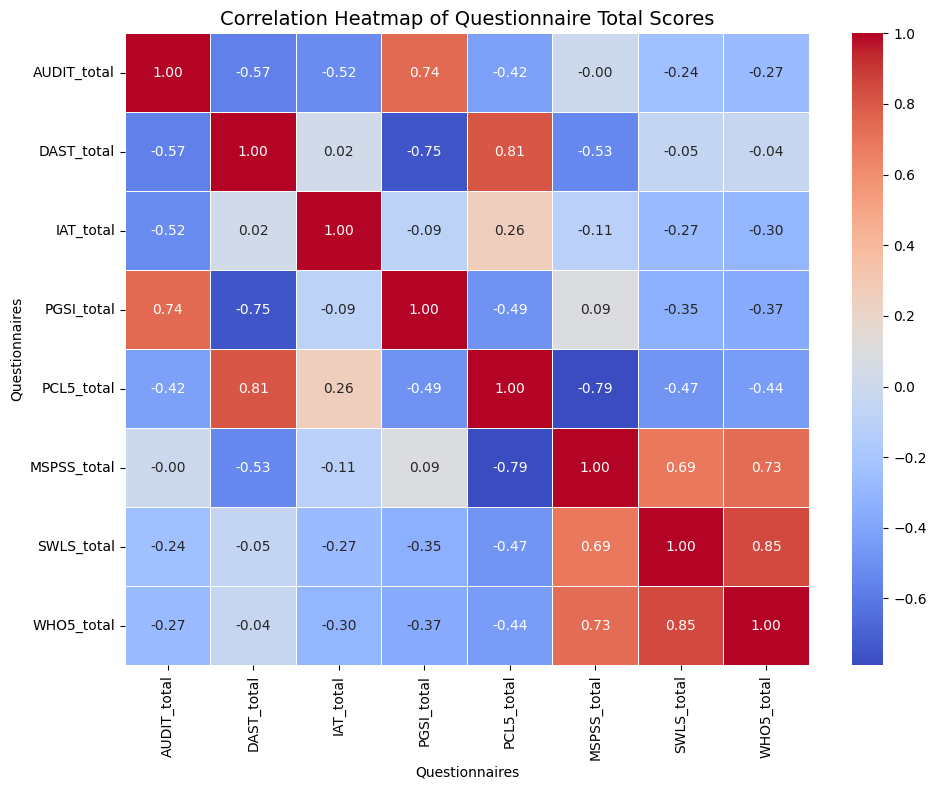

In [65]:
# Select only the total score columns
totals = [c for c in df_totals.columns if c.endswith("_total")]

# Compute the correlation matrix
corr = df_totals[totals].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,          
    cmap="coolwarm",      
    fmt=".2f",            
    linewidths=0.5
)

plt.title("Correlation Heatmap of Questionnaire Total Scores", fontsize=14)
plt.xlabel("Questionnaires")
plt.ylabel("Questionnaires")
plt.tight_layout()
plt.show()

Co-occurrence of addictions: Alcohol and gambling problems tend to appear together (shared behavioral tendencies).

Different addiction profiles: Drug use (DAST) behaves differently from alcohol/gambling, possibly indicating a separate risk group.

Mental-health context: PTSD symptoms (PCL5) correlate positively with substance-use problems and negatively with social support and well-being.

Protective factors: High social support (MSPSS) and life satisfaction (SWLS/WHO5) move together and counterbalance addiction and trauma scores.

making the heatmap which includes also age, gender, marital status, education, income

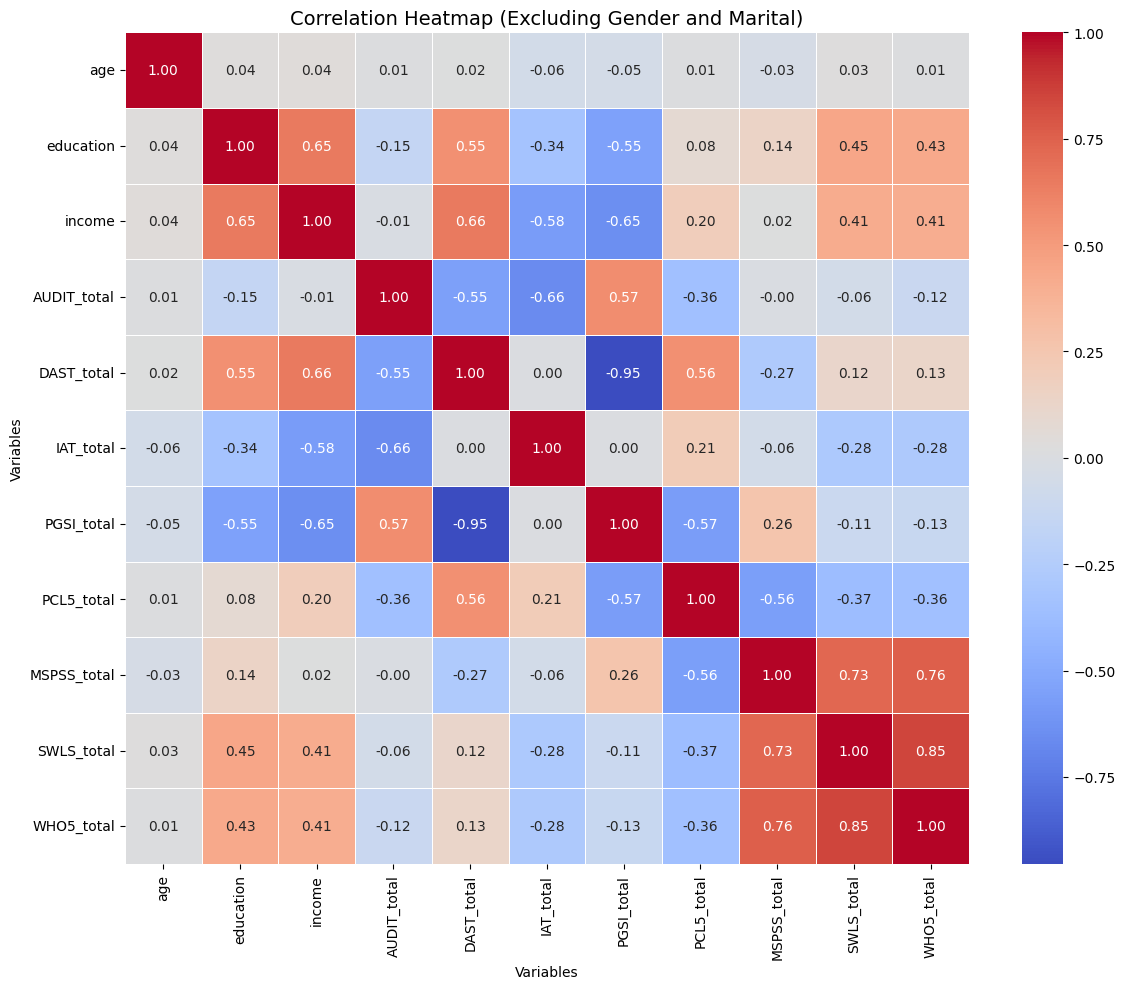

In [66]:
# Make a copy of your df_totals
df_numeric = df_totals.drop(columns=["gender", "marital"], errors="ignore")

# Keep only numeric columns
df_numeric = df_numeric.select_dtypes(include=["number"])

# Compute the correlation matrix (Spearman is best for ordinal/numeric mixes)
corr = df_numeric.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Excluding Gender and Marital)", fontsize=14)
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.tight_layout()
plt.show()



 The following thresholds are based on the official scoring manuals for each questionnaire. 
 Higher total scores on AUDIT, DAST, IAT, PGSI, and PCL-5 indicate greater severity of addiction 
 or psychological distress, while higher totals on MSPSS, SWLS, and WHO-5 indicate stronger social 
 support and well-being (protective factors). Because these scales are oriented in opposite directions, 
the well-being measures can be reverse-coded when needed so that higher values consistently represent 
 worse outcomes across all questionnaires. This ensures that correlation and clustering analyses are 
conceptually consistent and easier to interpret.

GRAPHS 

C:\Users\Visnja\AppData\Local\Temp\ipykernel_23588\3059155520.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


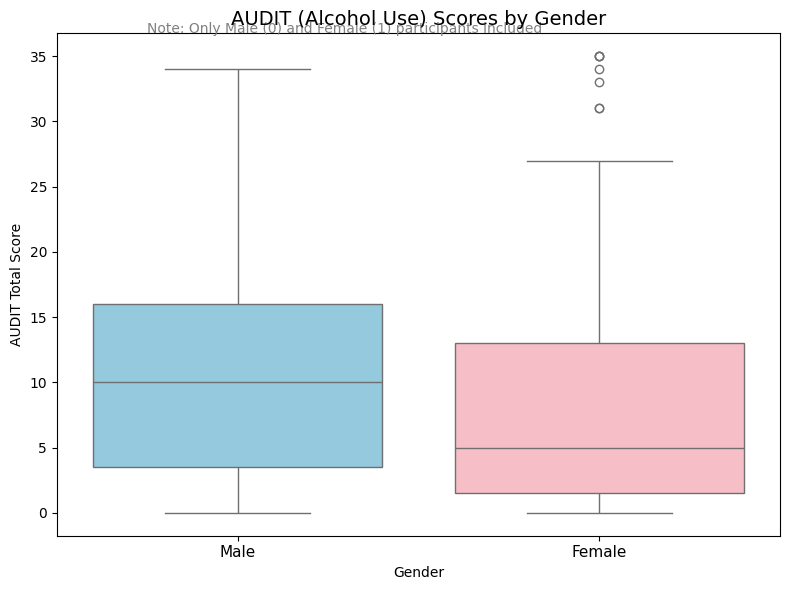

In [67]:
# Filter only male and female
import seaborn as sns
df_gender = df_totals[df_totals["gender"].isin([0, 1])].copy()

plt.figure(figsize=(8,6))

#  boxplot
sns.boxplot(
    x="gender",
    y="AUDIT_total",
    data=df_gender,
    palette=["skyblue", "lightpink"]
)


plt.title("AUDIT (Alcohol Use) Scores by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("AUDIT Total Score")


plt.xticks([0, 1], ["Male", "Female"], fontsize=11)


plt.text(-0.25, df_gender["AUDIT_total"].max() * 1.05,
         "Note: Only Male (0) and Female (1) participants included",
         fontsize=10, color="gray")

plt.tight_layout()
plt.show()

The median for males is higher → on average, men report more alcohol use than women.

The spread of male scores is also wider → greater variation among men (some drink very little, some very heavily).

The female group has a lower median and smaller variation, but still a few outliers (high-risk drinkers).

C:\Users\Visnja\AppData\Local\Temp\ipykernel_23588\3212357243.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\Visnja\AppData\Local\Temp\ipykernel_23588\3212357243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


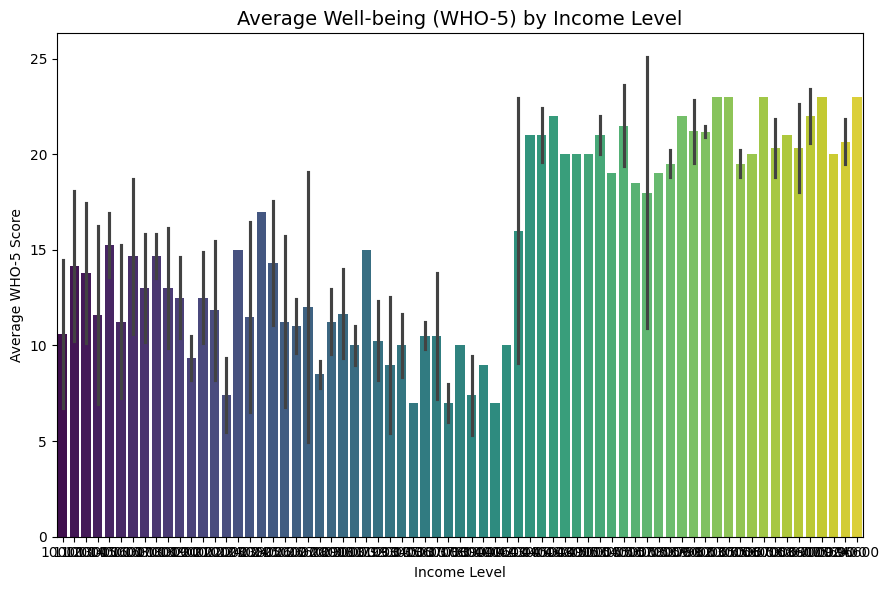

In [68]:
plt.figure(figsize=(9,6))

sns.barplot(
    x="income",
    y="WHO5_total",
    data=df_totals,
    estimator="mean",
    ci="sd",
    palette="viridis"
)

plt.title("Average Well-being (WHO-5) by Income Level", fontsize=14)
plt.xlabel("Income Level")
plt.ylabel("Average WHO-5 Score")

plt.tight_layout()
plt.show()


You can clearly see a positive trend: as income level increases, the average WHO-5 score tends to rise as well.
This means participants with higher income generally report better emotional well-being and life satisfaction.
Lower-income participants show lower and more variable well-being scores, suggesting more instability in reported happiness.
The relationship isn’t perfectly linear (some fluctuations), but the overall trend is upward.

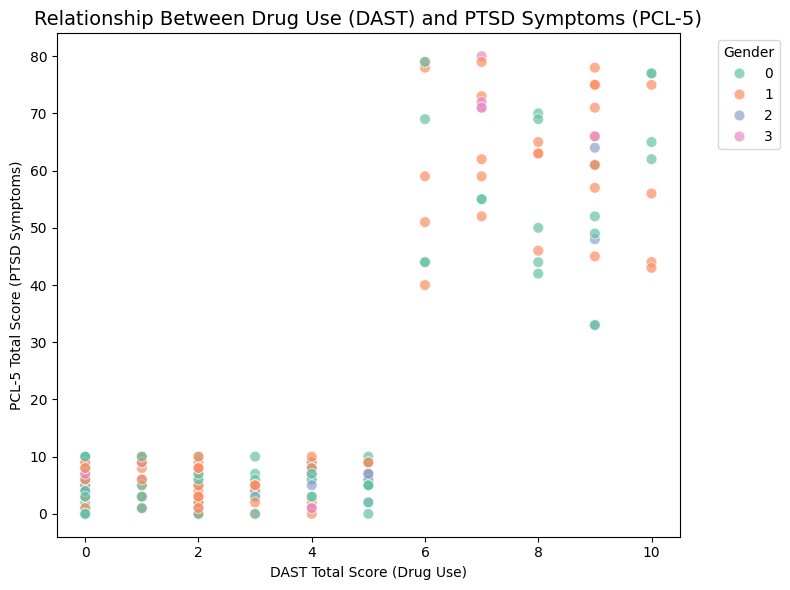

In [69]:

plt.figure(figsize=(8,6))

sns.scatterplot(
    x="DAST_total",
    y="PCL5_total",
    data=df_totals,
    hue="gender",           
    palette="Set2",
    alpha=0.7,
    s=60
)

plt.title("Relationship Between Drug Use (DAST) and PTSD Symptoms (PCL-5)", fontsize=14)
plt.xlabel("DAST Total Score (Drug Use)")
plt.ylabel("PCL-5 Total Score (PTSD Symptoms)")

plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Each point = one participant.

X-axis: level of drug use.

Y-axis: level of PTSD symptoms.

Color: participant’s gender (optional for visual separation).

Figure X demonstrates a strong positive relationship between drug use and PTSD symptoms. Participants with higher DAST scores consistently show elevated PCL-5 totals, indicating that greater substance use is associated with more severe trauma-related distress. This pattern aligns with evidence of comorbidity between substance use disorders and post-traumatic stress symptoms.

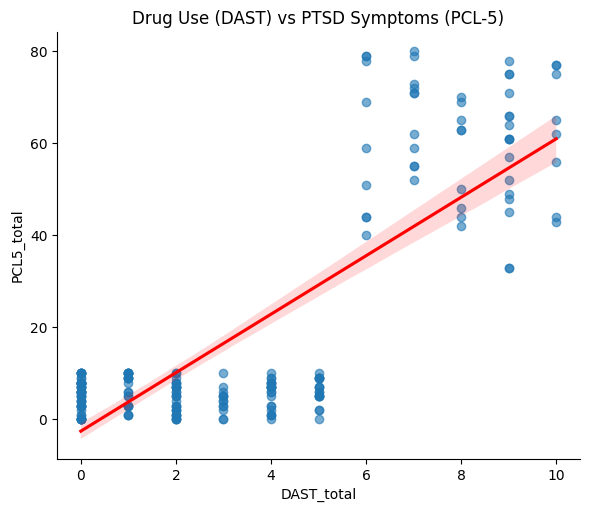

In [70]:
sns.lmplot(x="DAST_total", y="PCL5_total", data=df_totals, aspect=1.2, height=5, scatter_kws={"alpha":0.6}, line_kws={"color":"red"})
plt.title("Drug Use (DAST) vs PTSD Symptoms (PCL-5)")
plt.show()

NORMALIZED VALUES - to compare the problems

In [ ]:
# Select all questionnaire totals
# Modified here to take from df_combo cause i need the reversed ones!!
totals = [c for c in df_combo.columns if c.endswith("_total")]

# Normalize totals using RobustScaler
scaler = RobustScaler()
#scaler = MinMaxScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(df[totals]),
    columns=[f"{c}_robust" for c in totals]
)

# Keep personal columns (for post-hoc stats)
personal_cols = ["age","gender","education","marital","income"]
personal_cols = [c for c in personal_cols if c in df.columns]

# Merge
df_normalized = pd.concat([df[personal_cols], X_scaled], axis=1)

# Save
df_normalized.to_csv("normalized_totals.csv", index=False)
print("Saved normalized totals to 'normalized_totals.csv'")
print(totals)

Saved normalized totals to 'normalized_totals.csv'
['AUDIT_total', 'DAST_total', 'IAT_total', 'PGSI_total', 'PCL5_total', 'MSPSS_total', 'SWLS_total', 'WHO5_total']


DECIDING THE NUMBER OF CLUSTERS BY ELBOW METHOD - elbow is at 4

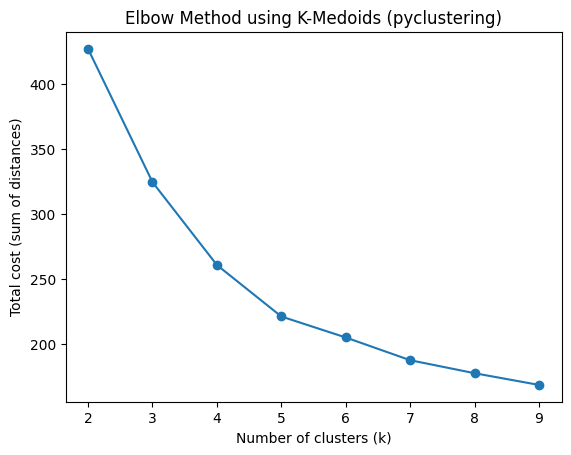

In [ ]:
# compute distance matrix
dist_matrix = pairwise_distances(X_scaled, metric='euclidean')

costs = []
K = range(2, 10)

for k in K:
    # initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))
    
    # run k-medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()
    # Manually compute total cost
    total_cost = 0
    for medoid_idx, cluster_indices in zip(medoids, clusters):
        for idx in cluster_indices:
            total_cost += dist_matrix[idx, medoid_idx]

    
    costs.append(total_cost)

# plot elbow
plt.plot(K, costs, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Total cost (sum of distances)")
plt.title("Elbow Method using K-Medoids (pyclustering)")
plt.show()


The elbow plot for the K-medoids solutions shows a steep decrease in total cost from k = 2 to k = 5, after which the curve flattens and additional clusters only marginally reduce the cost. This pattern suggests that a solution with around 4–5 clusters captures most of the structure in the data, while larger k values provide little improvement in model fit.

In [ ]:
silhouette_scores = []

for k in range(2, 10):
    # Initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))
    
    dist_matrix = pairwise_distances(X_scaled, metric='euclidean')
    np.fill_diagonal(dist_matrix, 0)  # Set diagonal to zero

    # Run k-medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    
    # Build labels array: assign the cluster index to each point
    labels = np.empty(len(X_scaled), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        labels[cluster] = cluster_idx
    
    # Compute silhouette score using the precomputed distance matrix
    score = silhouette_score(dist_matrix, labels, metric='precomputed')
    silhouette_scores.append(score)
    print(f"k={k}, silhouette score={score:.3f}")


k=2, silhouette score=0.740
k=3, silhouette score=0.560
k=4, silhouette score=0.579
k=5, silhouette score=0.542
k=6, silhouette score=0.489
k=7, silhouette score=0.487
k=8, silhouette score=0.408
k=9, silhouette score=0.367


k=2, silhouette score=0.767


In [ ]:
ch_scores = []
db_scores = []
K = range(2, 10)

dist_matrix = pairwise_distances(X_scaled, metric='euclidean')
np.fill_diagonal(dist_matrix, 0)

for k in K:
    # Initialize medoids randomly
    initial_medoids = list(np.random.choice(len(X_scaled), k, replace=False))

    # Run K-Medoids
    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()

    # Build label array: assign each sample to a cluster index
    labels = np.empty(len(X_scaled), dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        labels[cluster] = cluster_idx

    # Calculate CH and DB scores using true data and cluster labels
    ch = calinski_harabasz_score(X_scaled, labels)
    db = davies_bouldin_score(X_scaled, labels)

    ch_scores.append(ch)
    db_scores.append(db)

    print(f"k={k}, CH index={ch:.2f}, DB index={db:.3f}")


k=2, CH index=953.39, DB index=0.396
k=3, CH index=844.33, DB index=0.648
k=4, CH index=736.45, DB index=0.573
k=5, CH index=1048.05, DB index=0.643
k=6, CH index=984.41, DB index=0.820
k=7, CH index=1031.80, DB index=0.827
k=8, CH index=932.99, DB index=0.964
k=9, CH index=902.32, DB index=0.992


The internal validity indices showed mixed but informative patterns across different values of k. The Calinski–Harabasz (CH) index was relatively high for k = 2 and increased again for solutions with 5–8 clusters, with local peaks at k = 5 and k = 8, suggesting that more granular partitions can improve between-cluster separation. In contrast, the Davies–Bouldin (DB) index was lowest for k = 2 and increased for larger k, with comparatively favourable values around k = 4–5. Taken together with the elbow plot and the interpretability of the resulting groups, we focused on a 4–5 cluster solution and ultimately retained the 4-cluster model for further analyses.

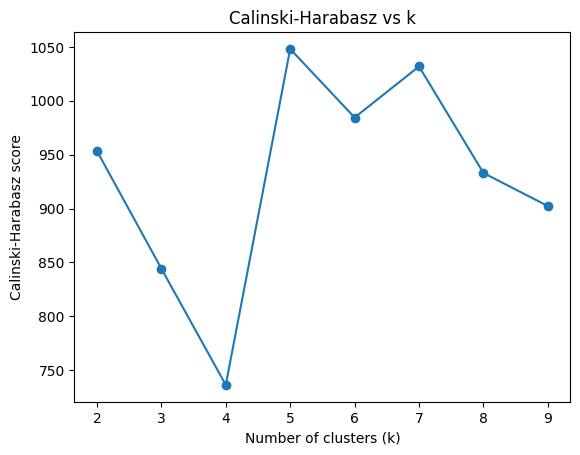

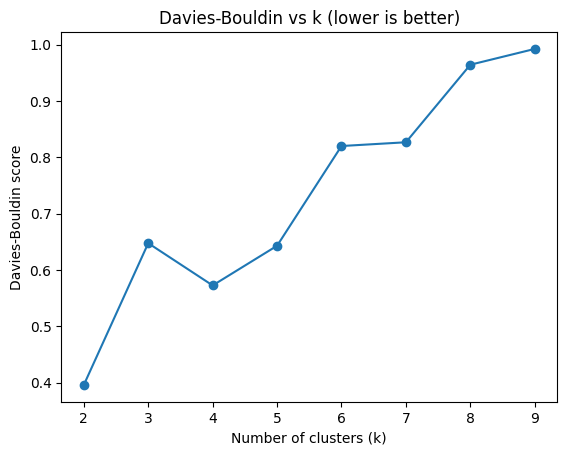

In [213]:
plt.figure()
plt.plot(K, ch_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz score')
plt.title('Calinski-Harabasz vs k')
plt.show()

plt.figure()
plt.plot(K, db_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin vs k (lower is better)')
plt.show()

In [ ]:
best_k = 4
dist_matrix = pairwise_distances(X_scaled, metric='euclidean')

result = kmedoids.fasterpam(dist_matrix, best_k)

df_normalized["cluster"] = result.labels

In [215]:
df_normalized.to_csv("clustered_sample.csv", index=False)
print("Saved normalized totals to 'clustered_sample.csv'")

Saved normalized totals to 'clustered_sample.csv'


In [ ]:
print(df_normalized["cluster"].value_counts())
cluster_means = df_normalized.groupby("cluster").mean()
print(cluster_means)

print(df_normalized["cluster"].value_counts())

cluster_means = df_normalized.groupby("cluster").mean()
print(cluster_means)

cluster
0    56
3    56
2    55
1    54
Name: count, dtype: int64
               age    gender  education   marital        income  \
cluster                                                           
0        29.053571  0.821429   8.000000  1.321429  18653.571429   
1        29.074074  0.888889  14.388889  1.574074  33285.185185   
2        29.400000  0.763636  19.709091  2.563636  61159.981818   
3        27.553571  0.785714  10.196429  0.910714  17617.839286   

         AUDIT_total_robust  DAST_total_robust  IAT_total_robust  \
cluster                                                            
0                  1.453297          -0.400000         -0.184896   
1                 -0.323362           1.214815          0.362654   
2                  0.269930           0.421818         -0.684848   
3                 -0.335165          -0.092857          0.865699   

         PGSI_total_robust  PCL5_total_robust  MSPSS_total_robust  \
cluster                                              

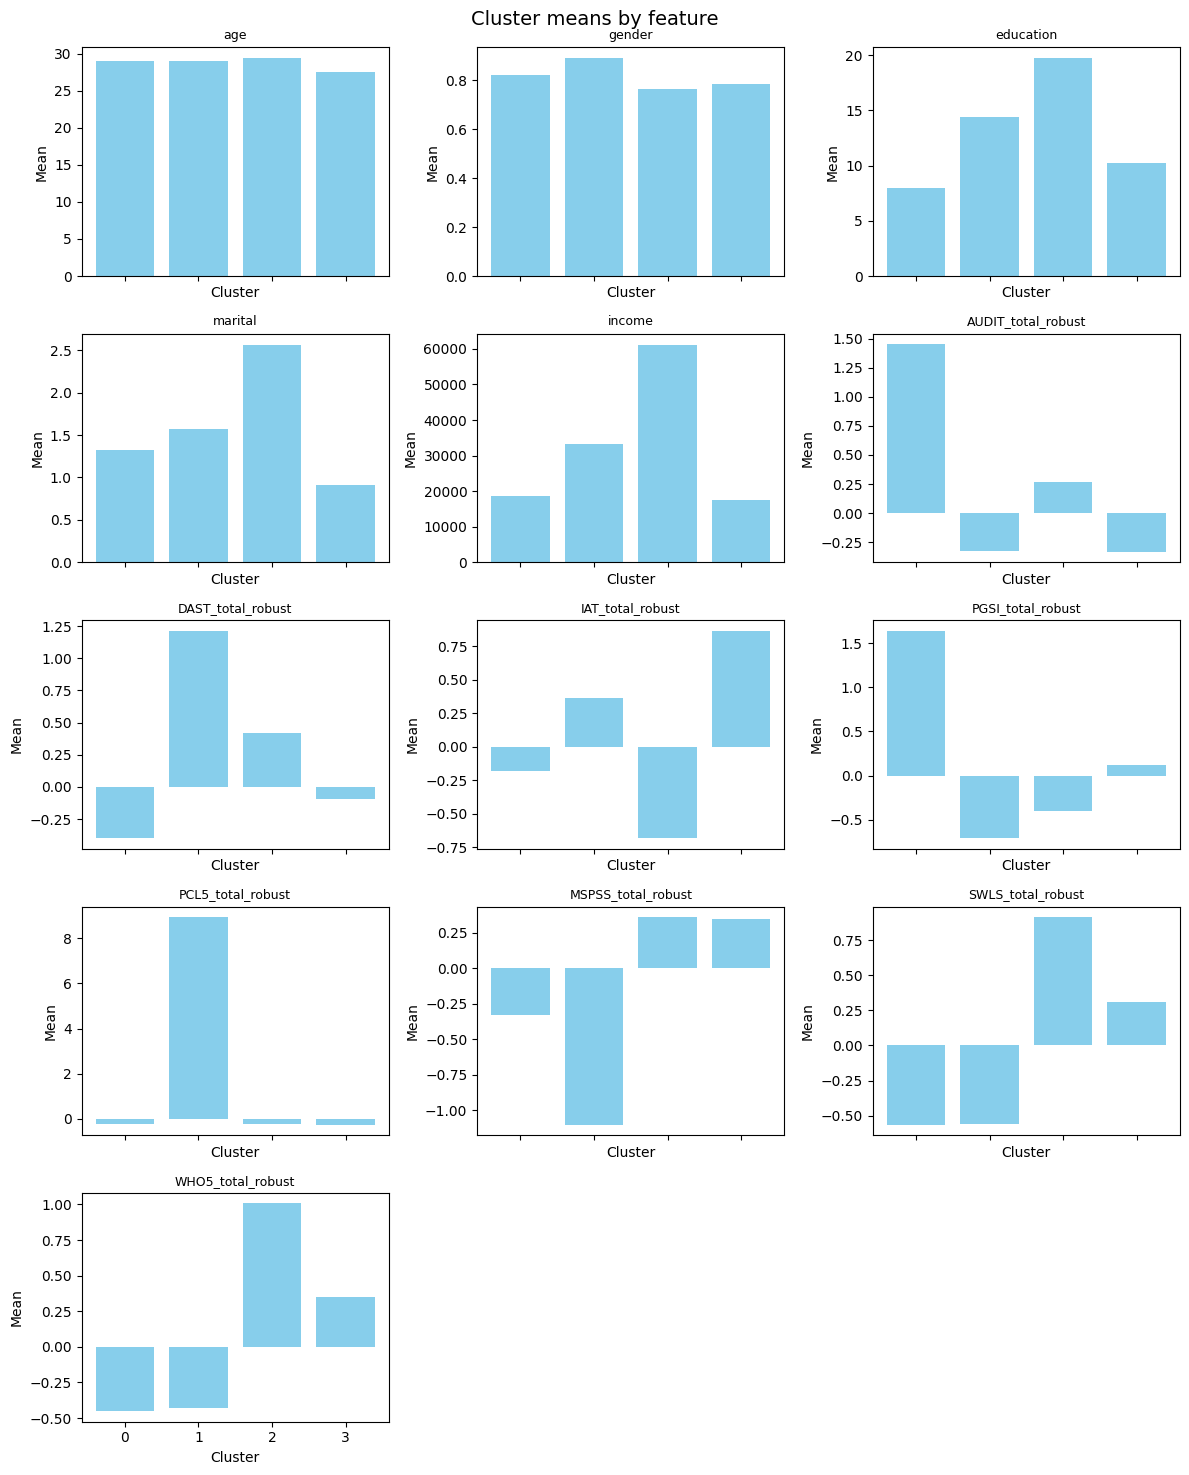

In [ ]:
import math
import matplotlib.pyplot as plt

# Compute cluster means
cluster_means = df_normalized.groupby("cluster").mean()
clusters = cluster_means.index.astype(str)

features = cluster_means.columns
n_features = len(features)

n_cols = 3 
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4 * n_cols, 3 * n_rows),
                         sharex=True)

axes = axes.ravel()

for ax, feature in zip(axes, features):
    ax.bar(clusters, cluster_means[feature], color="skyblue")
    ax.set_title(feature, fontsize=9)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean")

for ax in axes[len(features):]:
    ax.set_visible(False)

fig.suptitle("Cluster means by feature", fontsize=14)
plt.tight_layout()
plt.show()


In [218]:
print("Columns in cluster_means:")
for c in cluster_means.columns:
    print(c)

print("\nTotal features in cluster_means:", len(cluster_means.columns))

Columns in cluster_means:
age
gender
education
marital
income
AUDIT_total_robust
DAST_total_robust
IAT_total_robust
PGSI_total_robust
PCL5_total_robust
MSPSS_total_robust
SWLS_total_robust
WHO5_total_robust

Total features in cluster_means: 13


REPRESENTING CLUSTERS WITHOUT PCA

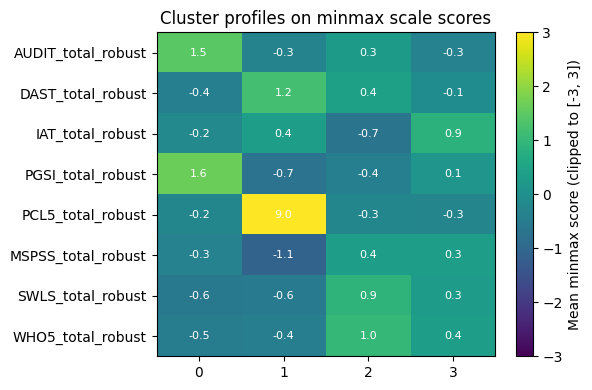

In [ ]:

# 1) Take only the robust-scaled variables
scale_cols = [c for c in df_normalized.columns if c.endswith("_robust")]

# 2) Compute the mean values per cluster
cluster_means_scales = df_normalized.groupby("cluster")[scale_cols].mean()

# 3) Clip values so outliers don't distort the color scale
data = cluster_means_scales[scale_cols].clip(lower=-3, upper=3).T  # shape: features x clusters

# 4) Plot
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(data, aspect="auto", vmin=-3, vmax=3)

ax.set_xticks(np.arange(len(cluster_means_scales.index)))
ax.set_xticklabels(cluster_means_scales.index)
ax.set_yticks(np.arange(len(scale_cols)))
ax.set_yticklabels(scale_cols)

ax.set_title("Cluster profiles on minmax scale scores")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Mean minmax score (clipped to [-3, 3])")

# 5) Numbers inside each cell
for x_idx, c in enumerate(cluster_means_scales.index):
    for y_idx, feat in enumerate(scale_cols):
        val = cluster_means_scales.loc[c, feat]
        ax.text(
            x_idx, y_idx,
            f"{val:.1f}",
            ha="center", va="center",
            fontsize=8, color="white"
        )

plt.tight_layout()
plt.show()


The heatmap displays mean robust scale scores for each of the four clusters. Positive values indicate scores above the sample median, while negative values indicate scores below it. Cluster 2 shows clearly elevated AUDIT and PGSI scores, indicating higher alcohol use and gambling problems. Cluster 3 stands out with an extremely high mean PCL-5 score and the lowest perceived social support, suggesting a group with pronounced post-traumatic stress symptoms and low support. Cluster 1 has the highest life satisfaction and well-being (SWLS, WHO-5) and relatively low risk scores, whereas Cluster 0 is characterized by elevated internet-use scores (IAT) with relatively average levels on the other scales.

In [ ]:
# 1) Select features and target
# assuming your features are the columns ending with *_robust
feature_cols = [c for c in df_normalized.columns if c.endswith("_robust")]
X = df_normalized[feature_cols]
y = df_normalized["cluster"]

print("Features used:", feature_cols)

# 2) Random Forest that learns to predict the clusters
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X, y)

# 3) Global feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("\nTop 10 features by RF importance:")
print(importances.head(10))

top3 = importances.head(3)
print("\nTOP 3 features:")
print(top3)


Features used: ['AUDIT_total_robust', 'DAST_total_robust', 'IAT_total_robust', 'PGSI_total_robust', 'PCL5_total_robust', 'MSPSS_total_robust', 'SWLS_total_robust', 'WHO5_total_robust']

Top 10 features by RF importance:
DAST_total_robust     0.164924
IAT_total_robust      0.156281
SWLS_total_robust     0.139267
WHO5_total_robust     0.129841
PGSI_total_robust     0.118547
AUDIT_total_robust    0.115398
MSPSS_total_robust    0.100234
PCL5_total_robust     0.075508
dtype: float64

TOP 3 features:
DAST_total_robust    0.164924
IAT_total_robust     0.156281
SWLS_total_robust    0.139267
dtype: float64


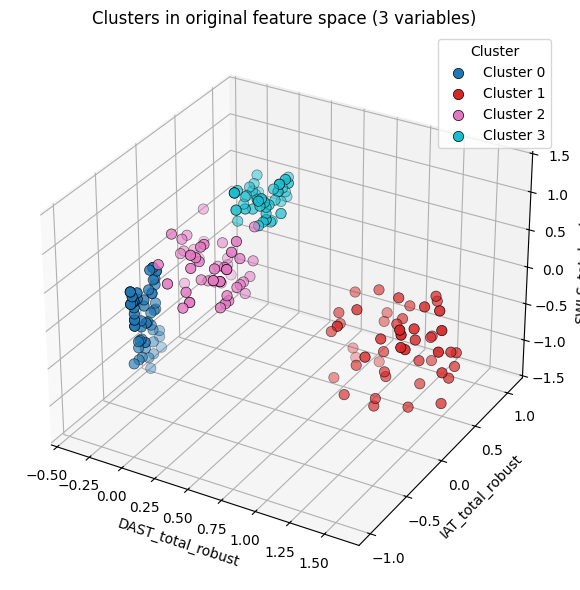

In [ ]:
feat_x = "DAST_total_robust"
feat_y = "IAT_total_robust"
feat_z = "SWLS_total_robust"

clusters = sorted(df_normalized["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

for c, col in zip(clusters, colors):
    sel = df_normalized["cluster"] == c
    ax.scatter(
        df_normalized.loc[sel, feat_x],
        df_normalized.loc[sel, feat_y],
        df_normalized.loc[sel, feat_z],
        s=55, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
    )

ax.set_xlabel(feat_x)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)
ax.set_title("Clusters in original feature space (3 variables)")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


PCA - representing on graph, reducing 8D to 3D

Kaiser (λ>1): suggested number of components = 2
Number of components needed for ≥90% variance = 2
Cumulative explained variance: [0.875 0.955 0.981 0.988 0.993 0.996 0.998 1.   ]

Using n_components = 2 for plotting/interpretation.


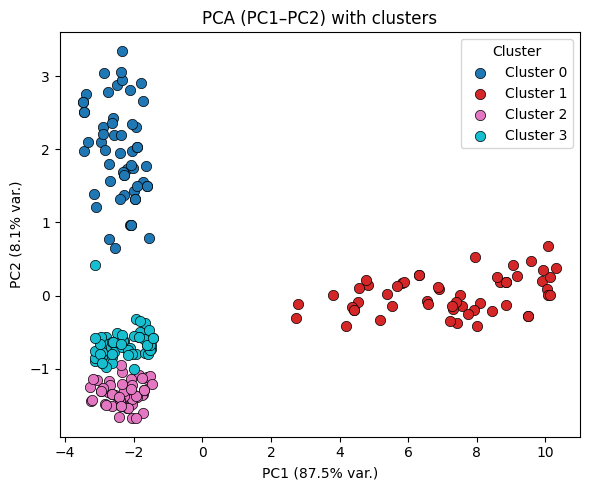

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 0) Assumption: X_scaled is already created, and df_normalized["cluster"] exists

# 1) PCA on all components
pca_full = PCA().fit(X_scaled)

# --- Kaiser method (λ > 1) ---
eigs = pca_full.explained_variance_
k_kaiser = int((eigs > 1.0).sum())
print(f"Kaiser (λ>1): suggested number of components = {k_kaiser}")

# --- ≥90% cumulative---
expl_var = pca_full.explained_variance_ratio_
cum_var = expl_var.cumsum()

k_90 = (cum_var >= 0.90).argmax() + 1
print(f"Number of components needed for ≥90% variance = {k_90}")
print("Cumulative explained variance:", np.round(cum_var, 3))

# 2) Choose the final number of components (e.g., the minimum of these two)
n_comp = min(k_kaiser, k_90)
print(f"\nUsing n_components = {n_comp} for plotting/interpretation.")

# 3) PCA with the selected number of components
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(X_scaled)

# DataFrame for plotting
cols = [f"PC{i+1}" for i in range(n_comp)]
pca_df = pd.DataFrame(X_pca, columns=cols)
pca_df["cluster"] = df_normalized["cluster"].values

expl_var_sel = pca.explained_variance_ratio_

# 4) 2D plot (PC1–PC2) – works only if we have at least 2 components
clusters = sorted(pca_df["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

if n_comp >= 2:
    plt.figure(figsize=(6, 5))
    for c, col in zip(clusters, colors):
        sel = pca_df["cluster"] == c
        plt.scatter(
            pca_df.loc[sel, "PC1"],
            pca_df.loc[sel, "PC2"],
            s=55, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
        )
    plt.xlabel(f"PC1 ({expl_var_sel[0]*100:.1f}% var.)")
    plt.ylabel(f"PC2 ({expl_var_sel[1]*100:.1f}% var.)")
    plt.title("PCA (PC1–PC2) with clusters")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


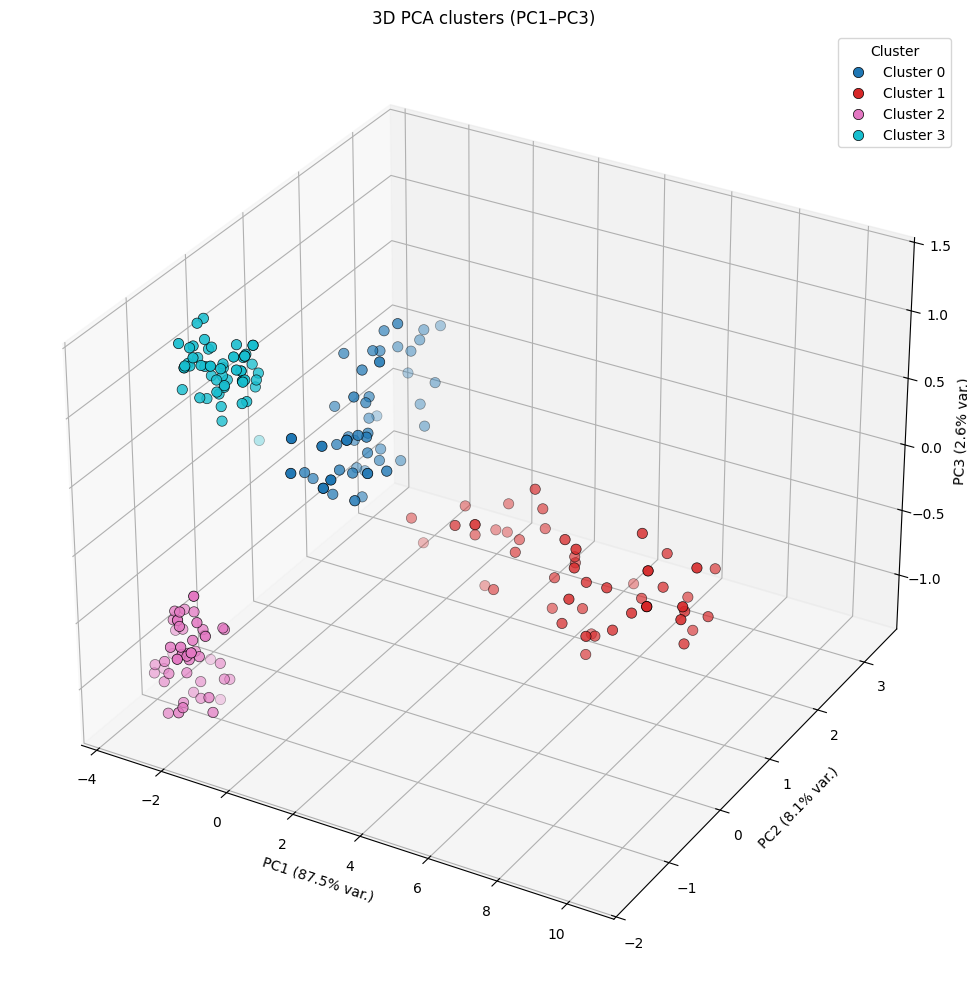

In [ ]:
# PCA with 3 components only for 3D visualization
pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)

pca3_df = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
pca3_df["cluster"] = df_normalized["cluster"].values

expl3 = pca3.explained_variance_ratio_

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection="3d")

clusters = sorted(pca3_df["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for c, col in zip(clusters, colors):
    sel = pca3_df["cluster"] == c
    ax.scatter(
        pca3_df.loc[sel, "PC1"],
        pca3_df.loc[sel, "PC2"],
        pca3_df.loc[sel, "PC3"],
        s=55, edgecolor="k", linewidth=0.5, color=col, label=f"Cluster {c}"
    )

ax.set_xlabel(f"PC1 ({expl3[0]*100:.1f}% var.)")
ax.set_ylabel(f"PC2 ({expl3[1]*100:.1f}% var.)")
ax.set_zlabel(f"PC3 ({expl3[2]*100:.1f}% var.)")
ax.set_title("3D PCA clusters (PC1–PC3)")
ax.legend(title="Cluster")
plt.tight_layout()
plt.show()


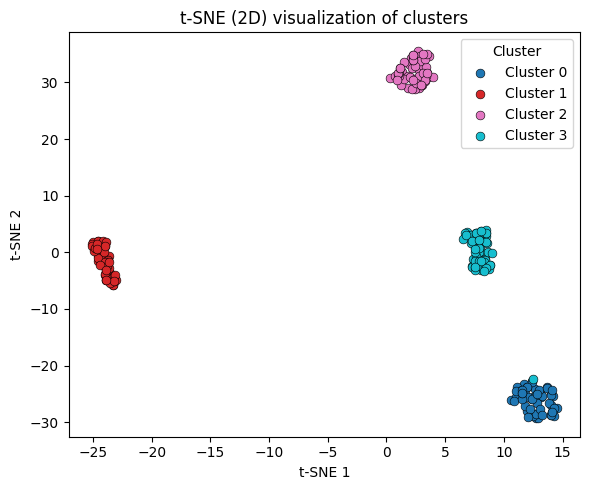

In [ ]:
X_array = X_scaled.values

tsne_2d = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,

    metric="euclidean",
    random_state=42
)

X_tsne_2d = tsne_2d.fit_transform(X_array)

tsne2_df = pd.DataFrame(X_tsne_2d, columns=["TSNE1", "TSNE2"])
tsne2_df["cluster"] = df_normalized["cluster"].values

clusters = sorted(tsne2_df["cluster"].unique())
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

plt.figure(figsize=(6, 5))
for c, col in zip(clusters, colors):
    sel = tsne2_df["cluster"] == c
    plt.scatter(
        tsne2_df.loc[sel, "TSNE1"],
        tsne2_df.loc[sel, "TSNE2"],
        s=40,
        edgecolor="k",
        linewidth=0.4,
        color=col,
        label=f"Cluster {c}"
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE (2D) visualization of clusters")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


We additionally explored non-linear embeddings using t-SNE. The two-dimensional t-SNE map showed a very clear separation between the four k-medoids clusters, whereas a three-dimensional t-SNE solution did not provide additional interpretability and therefore is not reported in detail.